# 18.06 Problem Set 8

Due Friday, April 8.

## Problem 1 (5+5+5 points)

Recall that a (real) unitary matrix $Q$ is a square matrix such that $Q^T = Q^{-1}$, or equivalently $\Vert Qx \Vert = \Vert x \Vert$ for any $x$.

We give a function `randQ(n)` below to generate a random $n\times n$ real unitary matrix $Q$ for testing purposes.

**(a)** From the properties of $Q$ above, what can you say about $\det Q$?   Check your deduction with a few random $Q$ matrices, calling `det(randQ(5))` or similar.

**(b)** From the properties of $Q$ above, what can you say about an eigenvalue $\lambda$ of $Q$, *if*  the eigenvalue is *real*?

**(c)** Compute the eigenvalues of a few random $3\times 3$ real unitary matrices, with `λ = eigvals(randQ(3))`.  What do you notice (no proofs required)?  Try plotting the imaginary parts of the eigenvalues versus the real parts, given by `imag.(λ)` and `real.(λ)` respectively, for a bunch of random Q's), using the code outline below.

In [1]:
using LinearAlgebra

# generate a random (Haar-uniform) n x n real unitary matrix
# using the algorithm from https://arxiv.org/abs/math-ph/0609050
function randQ(n)
    QR = qr(randn(n,n))
    return QR.Q * Diagonal(sign.(diag(QR.R)))
end

randQ (generic function with 1 method)

In [ ]:
# code outline for 1c:

using PyPlot
for i = 1:20
    # do some plotting of eigenvalues
end
axis("equal") # scale the x and y axes equally
title("problem 1c")
xlabel("real part")
ylabel("imaginary part")

# Solution
**(a)** Taking determinant of the equation $Q^T=Q^{-1}$, we get $\det(Q^T)=\det(Q^{-1})$. Since $\det(Q^T)=\det(Q)$, and $\det(Q^{-1})=\det(Q)^{-1}$, we obtain $\det(Q)=\det(Q)^{-1}$. Thus $\det(Q)$ must be $\boxed{1 \text{ or } -1}$. 

In [2]:
det(randQ(5))

-1.0000000000000002

**(b)** Suppose $\lambda$ is an eigenvalue of $Q$ and $x$ is the corresponding eigenvector. From $\lVert Qx\rVert=\lVert x\rVert$, we know $\lVert\lambda x\rVert=\lVert x\rVert$. Hence $\lvert \lambda\rvert=1$. If $\lambda$ is real, then $\lambda$ must be $\boxed{1 \text{ or } -1}$. 

**(c)**

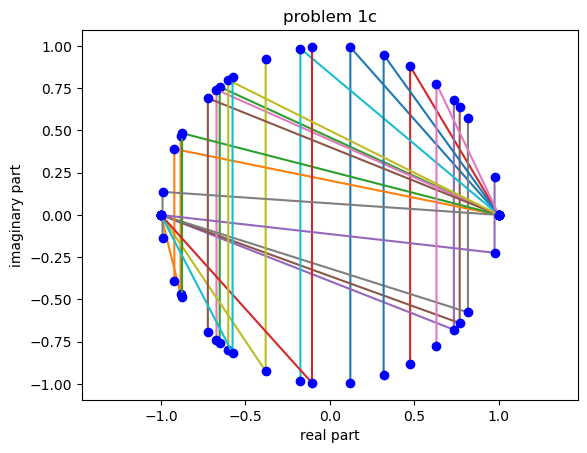

λ = ComplexF64[0.12097161320976654 - 0.9926559669882737im, 0.12097161320976654 + 0.9926559669882737im, 1.0000000000000002 + 0.0im]
λ = ComplexF64[-0.9999999999999998 + 0.0im, -0.8838074976210428 - 0.4678507316963722im, -0.8838074976210428 + 0.4678507316963722im]
λ = ComplexF64[-0.65216907018201 - 0.7580735478157324im, -0.65216907018201 + 0.7580735478157324im, 1.0 + 0.0im]
λ = ComplexF64[0.4748900871551568 - 0.8800451153899826im, 0.4748900871551568 + 0.8800451153899826im, 0.9999999999999999 + 0.0im]
λ = ComplexF64[-1.0 + 0.0im, 0.7337490970282505 - 0.6794205344337391im, 0.7337490970282505 + 0.6794205344337391im]
λ = ComplexF64[-1.0000000000000002 + 0.0im, 0.7681657915473628 - 0.6402509794575976im, 0.7681657915473628 + 0.6402509794575976im]
λ = ComplexF64[-0.671220200759032 - 0.7412580131728794im, -0.671220200759032 + 0.7412580131728794im, 0.9999999999999999 + 0.0im]
λ = ComplexF64[-0.999999999999999 + 0.0im, 0.8170431730618875 - 0.5765764939303046im, 0.8170431730618875 + 0.5765764939303

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\fuhao\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


PyObject Text(24.0, 0.5, 'imaginary part')

In [2]:
using PyPlot
for i = 1:20
    # do some plotting of eigenvalues
    λ=eigvals(randQ(3))
    @show λ
    plot(real.(λ),imag.(λ))
    plot(real.(λ),imag.(λ), "bo")
end
axis("equal") # scale the x and y axes equally
title("problem 1c")
xlabel("real part")
ylabel("imaginary part")

From the above figure, we can notice the following properties: (one can also find these result by looking at the numbers)
1. all the eigenvalues **lie on the unit circle**. (This essentially comes from the result $\lvert \lambda\rvert=1$ in (b), except that we haven't yet generalized our concept of $\Vert x \Vert$ to complex vectors.)
1. one can see many vertical lines, which means two eigenvalues have the same real part: the eigenvalues **come in complex-conjugate pairs**. With the first property, we know that if a complex value $\lambda$ is an eigenvalue, then its complex conjugate $\bar{\lambda}$ is also an eigenvalue. (This was proved in lecture 24.)
1. one can see many lines converging to two points. This means that **one of the eigenvalues is ±1**. (This is because the polynomial $\det(Q-\lambda I)$ has an odd degree and thus must have a real root: two of the eigenvalues are a complex-conjugate pair and so the remaining one must be real, not paired.)

## Problem 2 (5+5+5+5 points)

**(a)** If $P$ is a $3 \times 3$ projection matrix onto a 2d subspace of $\mathbb{R}^3$, then what is its determinant?

**(b)** If $A$ is an $11 \times 11$ matrix satisfying $A^T = -A$ (*anti*-symmetric), use the properties of determinants to say what $\det A$ must be.

**(c)** What are the determinants of $\begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix} \begin{pmatrix} 1 & -4 & 5 \end{pmatrix}$ and $\begin{pmatrix} 1 & -4 & 5 \end{pmatrix} \begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix}$?

**(d)** If $U = \begin{pmatrix} 1 & 4 & 6 \\ & 2 & 5 \\ & & 3 \end{pmatrix}$, what is the determinant of $U^{-3}$?

# Solution
**(a)** Since $P$ is singular, its determinant must be $\boxed{0}$. 

**(b)** Taking determinant of the equation $A^T=-A$, we get $\det(A^T)=\det(-A)$. Since $\det(A^T)=\det(A)$, and $\det(-A)=(-1)^{11}\det(A)$, we obtain $\det(A)=-\det(A)$. Thus $\det(A)$ must be $\boxed{0}$. 

**(c)** $\begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix} \begin{pmatrix} 1 & -4 & 5 \end{pmatrix}$ is a rank $1$ matrix, thus its determinant is $\boxed{0}$. $\begin{pmatrix} 1 & -4 & 5 \end{pmatrix} \begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix}=8$, thus its determinant is $\boxed{8}$. 

**(d)** $\det(U)=1\times 2\times 3=6$. Then $\det(U^{-3})=6^{-3}=\boxed{\frac{1}{216}}$. 

## Problem 3 (5+5+5+5 points)

$A = \begin{pmatrix}
1 & -1 & -1 \\
-1 & 1 & 0 \\
-1 & -1 & 0 
\end{pmatrix}$ has eigenvalues $\lambda_1 = -1$, $\lambda_2 = 1$, and $\lambda_3 = 2$ and corresponding eigenvectors are $x_1 = \begin{pmatrix} 2 \\ 1 \\ 3 \end{pmatrix}$, $x_2 = \begin{pmatrix} 0 \\ 1 \\ -1 \end{pmatrix}$, and $x_3 = \begin{pmatrix} -1 \\ 1 \\ 0 \end{pmatrix}$.

Find the eigenvectors and eigenvalues of the following matrices.  (If you find yourself trying to solve a cubic equation, stop!  **Very little calculation** should be required.)

**(a)** $2A$

**(b)** $A^3$

**(c)** $2I + 3A + 4A^2$

**(d)** $P A P$ where $P = \begin{pmatrix} & 1 & \\ 1 & & \\ & & 1 \end{pmatrix}$.  (Hint:  What does $P$ do to a vector? What is $P^{-1}$?  Hence $PAP$ and $A$ are \_\_\_\_\_\_\_\_\_\_.)

# Solution
If $Ax=\lambda x$, then $cAx=c\lambda x$ and $A^nx=\lambda^nx$. Also, note $(A+\alpha I)x = (\lambda+\alpha)x$.  More generally, for any polynomial $f(t)$, we have $f(A)x=f(\lambda)x$: $x$ is an an eigenvector with eigenvalue $f(\lambda)$.

**(a)** $f(t)=2t$. Thus eigenvalues are $f(\lambda_1) = -2$, $f(\lambda_2) = 2$, and $f(\lambda_3) = 4$, while corresponding eigenvectors are $x_1$, $x_2$, and $x_3$. 

**(b)** $f(t)=t^3$. Thus eigenvalues are $f(\lambda_1) = -1$, $f(\lambda_2) = 1$, and $f(\lambda_3) = 8$, while corresponding eigenvectors are $x_1$, $x_2$, and $x_3$. 

**(c)** $f(t)=2+3t+4t^2$. Thus eigenvalues are $f(\lambda_1) = 3$, $f(\lambda_2) = 9$, and $f(\lambda_3) = 24$, while corresponding eigenvectors are $x_1$, $x_2$, and $x_3$. 

**(d)** Note that $P^{-1}=P$, hence $PAP=PAP^{-1}$ is similar to $A$. If $Ax=\lambda x$, then $(PAP^{-1})(Px)=PAx=P(\lambda x)=\lambda (Px)$. Thus eigenvalues are $\lambda_1 = -1$, $\lambda_2 = 1$, and $\lambda_3 = 2$, while corresponding eigenvectors are $Px_1 = \begin{pmatrix} 1 \\ 2 \\ 3 \end{pmatrix}$, $Px_2 = \begin{pmatrix} 1 \\ 0 \\ -1 \end{pmatrix}$, and $Px_3 = \begin{pmatrix} 1 \\ -1 \\ 0 \end{pmatrix}$.

## Problem 4 (10+5 points)

For the matrix $A$ of problem 3:

**(a)** Compute $A^{50} x$ where $x = \begin{pmatrix} 3 \\ -1 \\ 4 \end{pmatrix}$.

**(b)** Check your answer in Julia.

# Solution

**(a)** First write $x$ in the basis of eigenvectors. There are many ways to get the result. Here is one possible method.

Note that $x_2$ and $x_3$ are orthogonal to the vector $v=\begin{pmatrix}1&1&1\end{pmatrix}^T$. Taking the dot product with $v$, we find the coefficient of $x_1$ is $1$. $x-x_1=\begin{pmatrix}1&-2&1\end{pmatrix}^T$. Since the first entry of $x_2$ and the third entry of $x_3$ is $0$, it is clear that $x-x_1=-x_2-x_3$. In conclusion, $x=x_1-x_2-x_3$. 

Thus $A^{50}x=A^{50}(x_1-x_2-x_3)=A^{50}x_1-A^{50}x_2-A^{50}x_3=\lambda_1^{50}x_1-\lambda_2^{50}x_2-\lambda_3^{50}x_3=x_1-x_2-2^{50}x_3=\boxed{\begin{pmatrix}2+2^{50}\\-2^{50}\\4\end{pmatrix}}$. 

Note that the solution is nearly parallel to $x_3$: $A^n x$ for large $n$ is **always dominated** by the eigenvector(s) with largest $|\lambda|$, which here is $|\lambda_3|=2$. 

**(b)**

In [5]:
A=[1 -1 -1;
-1 1 0;
-1 -1 0]
x=[3, -1, 4]
A^50 * x

3-element Vector{Int64}:
  1125899906842626
 -1125899906842624
                 4

## Problem 5 (10 points)

(From Strang section 5.1, problem 18.)

Use row operations to show that this $3 \times 3$ "Vandermonde determinant" is:
$$
\det \begin{pmatrix}1 & a & a^2 \\ 1 & b & b^2 \\ 1 & c & c^2 \end{pmatrix} =
(b-a) (c-a) (c-b) \, .
$$

# Solution

We just perform Gaussian-elimination steps (row subtractions, which don't change the determinant) to put the matrix in upper-triangular form, factoring out scale factors using linearity, and finally just multiply the diagonals:

$$
\det \begin{pmatrix}1 & a & a^2 \\ 1 & b & b^2 \\ 1 & c & c^2 \end{pmatrix}=\det \begin{pmatrix}1 & a & a^2 \\ 0 & b-a & b^2-a^2 \\ 0 & c-a & c^2-a^2 \end{pmatrix}\\
=(b-a)(c-a)\det \begin{pmatrix}1 & a & a^2 \\ 0 & 1 & b+a \\ 0 & 1 & c+a \end{pmatrix}\\
=(b-a)(c-a)\det \begin{pmatrix}1 & a & a^2 \\ 0 & 1 & b+a \\ 0 & 0 & c-b \end{pmatrix}\\
=(b-a)(c-a)(c-b). 
$$